# Redes Neurais
## Prática I - Classificação de padrões

## Base de dados: Ionosphere

In [1]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt 
import seaborn as sns 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def piecewise_norm(vec,val,n):
    assert val > min(vec)
    
    return np.where(vec < val, n*(vec - min(vec))/(val - min(vec)), (1-n)*(vec - val)/(max(vec) - val) + n)

In [3]:
def transform_data(dataset,dataset_columns,normalize=True):
    new_df = pd.DataFrame()
    for name in dataset.columns:
        if name in dataset_columns.keys():
            
            if dataset_columns[name] == 'categorical':
                raw_data = dataset[name].values
                d_encoder = LabelEncoder()
                d_encoder.fit(raw_data)
                d_encoded = d_encoder.transform(raw_data)
                dummy_y = to_categorical(d_encoded)
                #print(dummy_y.shape)
                
                for (j,k) in enumerate(d_encoder.classes_):
                    new_df[f'{name}_{k}'] = dummy_y[:,j].astype('int')
            
            
            elif dataset_columns[name] == 'numeric':
                raw_data = dataset[name].values
                if normalize:
                    new_df[name] = (raw_data - min(raw_data))/(max(raw_data) - min(raw_data))
                else:
                    new_df[name] = raw_data
                
            elif dataset_columns[name] == 'original':
                new_df[name] = dataset[name].values
            
            elif dataset_columns[name] == 'target':
                new_df[name] = dataset[name].values
                
    return new_df

In [4]:
def create_model(hidden_neurons = [4], hidden_activation = ['relu'], output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    model = Sequential()
    model.add(Dense(hidden_neurons[0], input_dim=n_input, activation='relu'))
    for i in range(1,len(hidden_neurons)):
        model.add(Dense(hidden_neurons[i], input_dim=hidden_neurons[i-1], activation='relu'))
        

    model.add(Dense(n_output, activation=output_activation))
    # Compile model
    opt = Adam(lr=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Preparação dos dados

In [5]:
with open('data_info.json','r') as f:
    dataset_columns = json.load(f)

In [6]:
dataset = pd.read_csv('class_ionosphere.csv')

## Parte I - Compreensão do problema e análise de variáveis



### 1)	Observe a base de dados do problema. Existem variáveis que podem ser eliminadas do dataset? Justifique.

#### Rascunho

In [7]:
dataset

,info_0,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,...,info_25,info_26,info_27,info_28,info_29,info_30,info_31,info_32,info_33,target
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1,0,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,...,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307,g
347,1,0,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,...,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712,g
348,1,0,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,...,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577,g
349,1,0,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,...,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243,g


In [9]:
dataset.values[:,0]#verificando a primeira coluna ->  possui 0 e 1, não vamos excluir

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [10]:
dataset.values[:,1]#verificando a segunda coluna -> coluna inteira de zeros, vamos excluir

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [11]:
dataset.drop(columns="info_1",inplace=True)

#### Resposta

In [12]:
dataset.head()

,info_0,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,...,info_25,info_26,info_27,info_28,info_29,info_30,info_31,info_32,info_33,target
0,1,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


### 2)	Implemente técnicas de visualização de dados e seleção de variáveis para extrair características importantes sobre a base de dados. Explique a motivação destas técnicas e o que é possível inferir dos resultados obtidos.

#### Rascunho

#### Resposta

In [ ]:
#sns.pairplot(dataset[['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compacity','concavity', 'pts_concavity', 'symmetry', 'fractal','target']], hue="target", diag_kind="hist")
#sns.pairplot(dataset[['radius', 'texture', 'perimeter', 'area', 'target']], hue="target", diag_kind="hist")

## 2.	Treinamento do modelo de Rede Neural

### 1)	Com as configurações do modelo MLP previamente definidas no script, faça o treinamento da Rede Neural sem normalizar os atributos numéricos. Comente o resultado obtido, baseado nas métricas de avaliação disponíveis (acurácia, precision, recall, F1-Score, Matriz de confusão, etc.)

#### Rascunho

In [13]:
#Parâmetros do modelo 

hidden_neurons = [15]
activation_layers = ['relu']

output_activation = 'sigmoid'

lr = 0.05
epochs = 50

In [14]:
new_df = transform_data(dataset,dataset_columns,normalize=False)
new_df.head()

,info_0,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,...,info_25,info_26,info_27,info_28,info_29,info_30,info_31,info_32,info_33,target
0,1,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [15]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
Y = encoder.fit_transform(target)

n_input = X.shape[1]
n_output = 1

33

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0])

In [17]:
model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 526
Trainable params: 526
Non-trainable params: 0
_________________________________________________________________


#### Resposta

In [18]:
model.fit(x=x_train,y=y_train,epochs=epochs)

Epoch 1/50
9/9 [==============================] - 1s 4ms/step - loss: 0.5498 - accuracy: 0.7346
Epoch 2/50
9/9 [==============================] - 0s 1ms/step - loss: 0.2430 - accuracy: 0.9342
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 0.2149 - accuracy: 0.9181
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1356 - accuracy: 0.9420
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1175 - accuracy: 0.9635
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1242 - accuracy: 0.9543
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 0.0903 - accuracy: 0.9630
Epoch 8/50
9/9 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.9764
Epoch 9/50
9/9 [==============================] - 0s 1ms/step - loss: 0.0825 - accuracy: 0.9806
Epoch 10/50
9/9 [==============================] - 0s 1ms/step - loss: 0.0431 - accuracy: 0.9858
Epoch 11/50
9/9 [======================

In [19]:
raw_Y_pred = model.predict(x_test)
y_pred = np.where(raw_Y_pred > 0.5, 1, 0)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print('Classification Report')
target_names = ['0','1']
print(classification_report(y_test, y_pred, target_names=target_names))

Confusion Matrix
[[23  5]
 [ 1 42]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.82      0.88        28
           1       0.89      0.98      0.93        43

    accuracy                           0.92        71
   macro avg       0.93      0.90      0.91        71
weighted avg       0.92      0.92      0.91        71



Text(0.5, 15.0, 'Predicted')

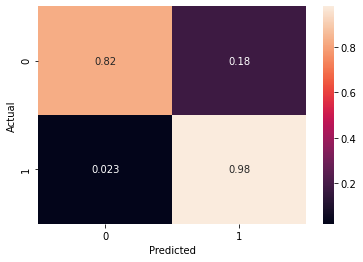

In [20]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn,annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### 2)	Agora normalize os dados de entrada e treine novamente o modelo MLP. Avalie os resultados obtidos e comente o efeito da normalização no treinamento da Rede Neural.

#### Rascunho

In [ ]:
new_df = transform_data(dataset,dataset_columns,normalize=True)
new_df.head()

In [ ]:
del model 


#### Resposta

In [ ]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
Y = encoder.fit_transform(target)

n_input = X.shape[1]
n_output = 1

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [ ]:
model = create_model(hidden_neurons=hidden_neurons,output_activation=output_activation,n_input=n_input,n_output=n_output, lr = lr)

In [ ]:
model.summary()

In [ ]:
model.fit(x=x_train,y=y_train,epochs=epochs)


In [ ]:
raw_Y_pred = model.predict(x_test)
y_pred = np.where(raw_Y_pred > 0.5, 1, 0)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print('Classification Report')
target_names = ['0','1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn,annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Parte III - Mudança de configurações do modelo

### 1)	Insira o conjunto de validação para o treinamento do modelo. Avalie o resultado obtido.

#### Rascunho

In [ ]:
del model


#### Resposta

### 2)	Modifique o tempo de treinamento (épocas) da Rede Neural. Escolha dois valores distintos (e.g. 1 e 1000 épocas) e avalie os resultados.

#### Rascunho

#### Resposta

### 3)	 Modifique a taxa de aprendizado da Rede Neural. Escolha dois valores distintos (e.g. 0,001 e 0,1) e avalie os resultados.

#### Rascunho

#### Resposta

### 4)	Modifique a quantidade de neurônios na camada escondida da Rede Neural. Escolha dois valores distintos (e.g. 2 e 70 neurônios) e avalie os resultados.

#### Rascunho

#### Resposta

## Parte IV - Análise dos resultados

### 1)	Faça novos testes para avaliar o desempenho da Rede Neural no problema designado. Use a técnica K-Fold (com K = 10) para analisar o resultado obtido.

#### Rascunho

#### Resposta

### 2)	Faça análises e novas implementações que você julgue importante para o seu trabalho. Não esqueça de explicar a motivação da análise realizada. 

#### Rascunho

#### Resposta